<a href="https://colab.research.google.com/github/Yeganehfrh/B2BC_hypnotic_interaction/blob/main/PLB_HYP_EEG_Preproecessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up the Environment

In [6]:
# install necessary tools
!pip install mne mne_bids pymanopt git+https://github.com/nbara/python-meegkit.git

  Cloning https://github.com/nbara/python-meegkit.git to /tmp/pip-req-build-zee0w593
  Running command git clone -q https://github.com/nbara/python-meegkit.git /tmp/pip-req-build-zee0w593
  Created wheel for meegkit: filename=meegkit-0.1.1-cp37-none-any.whl size=63827 sha256=c28dff37838dc4d4e6ff3c34d6f1e49f44b5764e5bf9315ef520205a0bf8a7a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-222kc149/wheels/d4/ee/26/a6c8416ac13b525758ba92c97a95de7ac19512c61261479027
Successfully built meegkit


In [5]:
# import necessary modules
import os
import numpy as np
import mne
import os.path as op
#from mne_bids.copyfiles import copyfile_brainvision
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftshift
from meegkit import dss

## Open EEG data from Google Drive

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
# unzip or unrar if needed
# !unzip /content/drive/MyDrive/PLB-HYP\ OTKA1_EEG\ data/OTKA1_test0006.zip -d /content/
# !unrar e "/content/drive/MyDrive/rename_temporary/OTKA_rename.rar" "/content/"
# with open('/content/OTKA1_test0006/OTKA1_test0006.vmrk') as f:
#   content = f.read()
# print(content)

Extracting parameters from /content/drive/MyDrive/Live Sessions/plb-hyp-live2131111.vhdr...
Setting channel info structure...


<ipython-input-9-95e93ca49f52>:2: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision('/content/drive/MyDrive/Live Sessions/plb-hyp-live2131111.vhdr')


Effective window size : 2.048 (s)


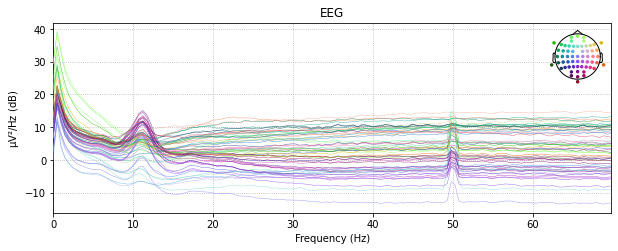

In [9]:
# Open EEG data and visualize its power spectrum density
raw = mne.io.read_raw_brainvision('/content/drive/MyDrive/Live Sessions/plb-hyp-live2131111.vhdr')
ax = raw.plot_psd(fmax= 70)

Effective window size : 2.048 (s)


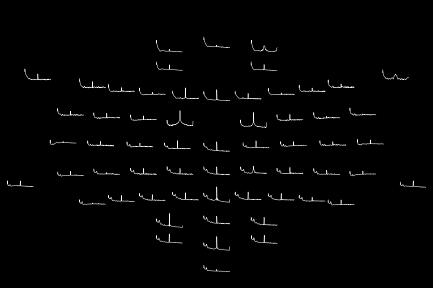

In [20]:
ax = raw.plot_psd_topo()

Effective window size : 2.048 (s)


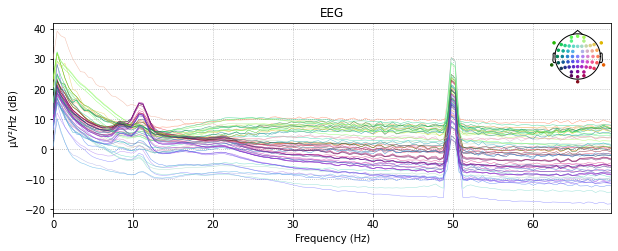

In [9]:
ax = raw.plot_psd(fmax= 70, reject_by_annotation = False, picks = ['eeg'],
                   area_mode = 'range', estimate='auto')

<ipython-input-19-356b683aa61a>:9: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(session_file, verbose= False)
<ipython-input-19-356b683aa61a>:9: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(session_file, verbose= False)
<ipython-input-19-356b683aa61a>:9: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(session_file, verbose= False)
<ipython-input-19-356b683aa61a>:9: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(session_fi

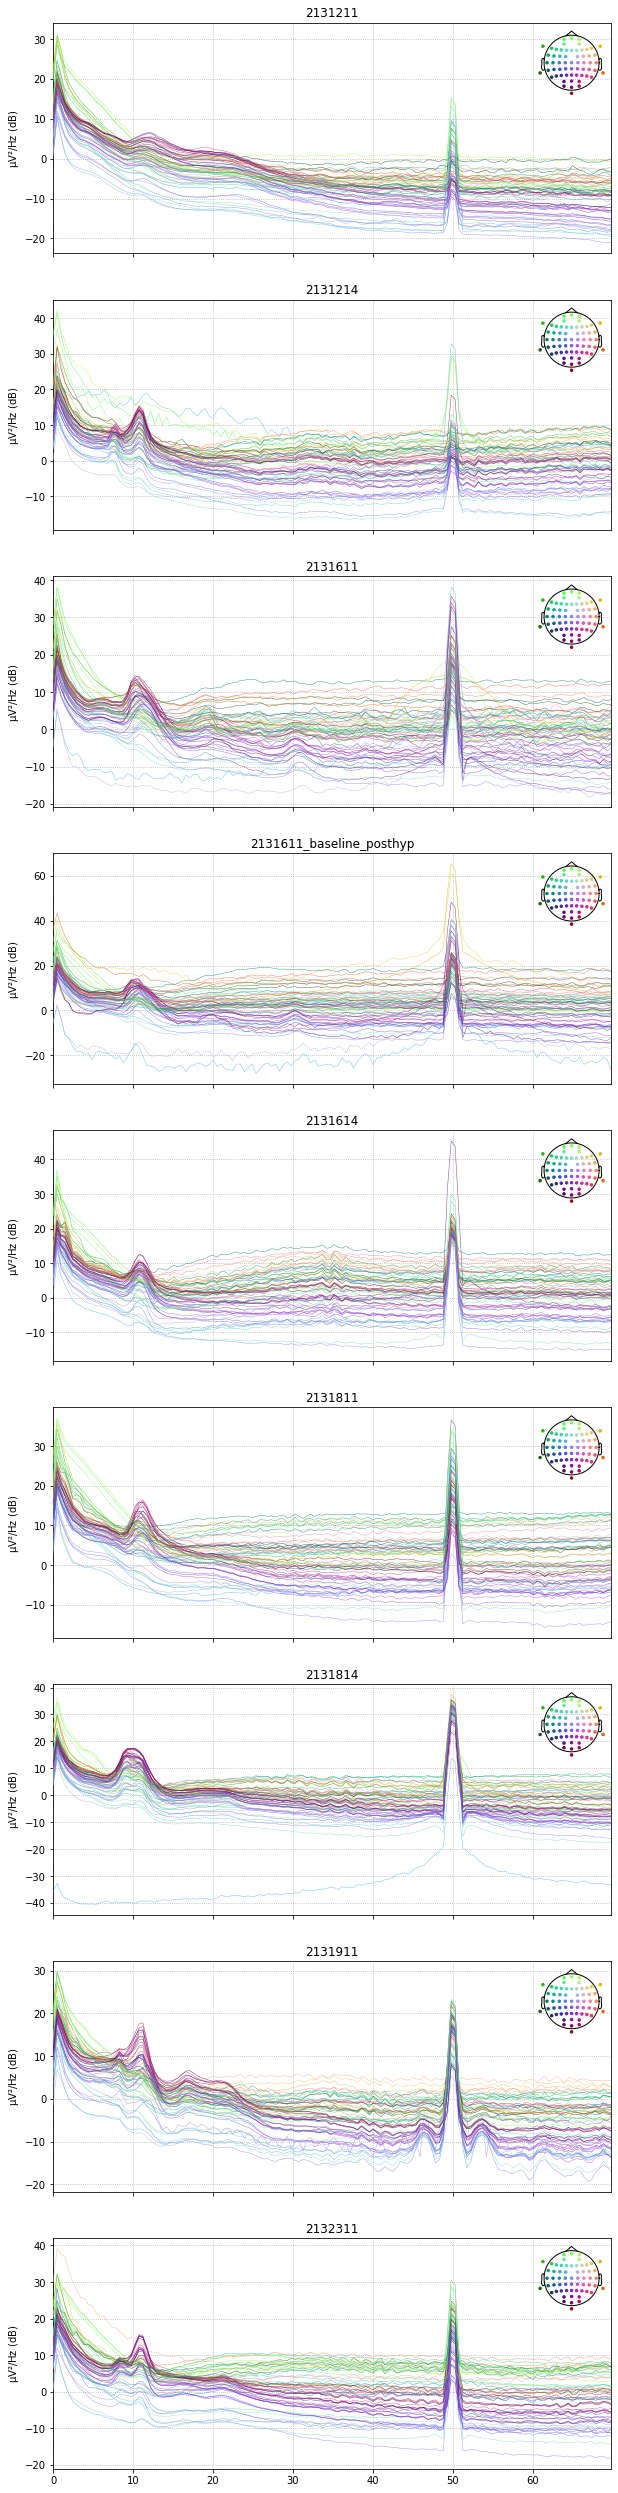

In [19]:
from pathlib import Path

sessions_dir = Path('/content/drive/MyDrive/Live Sessions/')
session_files = list(sessions_dir.glob('213*.vhdr'))
n_subs = len(session_files)

fig, axes = plt.subplots(n_subs, 1, sharex= True, figsize = (10,n_subs * 5))
for i, session_file in enumerate(session_files):
  raw = mne.io.read_raw_brainvision(session_file, verbose= False)
  raw.plot_psd(fmax= 70, ax = axes[i], show= False, verbose = False)
  axes[i].set(title = session_file.stem)

plt.show()

# Preprocessing

In [ ]:
# remove power line noise with Zapline or spectrum interpolation

In [ ]:
# removing power line noise
freqs = (50, 100, 150, 200)
raw_notch = raw.copy().notch_filter(freqs=freqs)
for title, data in zip(['Un', 'Notch '], [raw, raw_notch]):
    fig = data.plot_psd(fmax=250, average=True)
    fig.subplots_adjust(top=0.85)
    fig.suptitle('{}filtered'.format(title), size='xx-large', weight='bold')

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  9']
Not setting metadata
Not setting metadata
22 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 701 original time points ...
0 bad epochs dropped


<ipython-input-6-44f147ae6547>:7: RuntimeWarning: event 99999 missing from event_id will be ignored
  first_samp=raw.first_samp, event_id=event_dict)


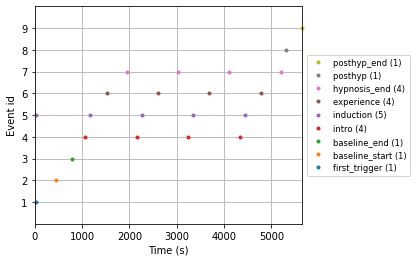

In [6]:
# epoching continuous data
events, event_dict = mne.events_from_annotations(raw)
event_dict = {'first_trigger': 1, 'baseline_start': 2, 'baseline_end': 3,
              'intro': 4, 'induction': 5, 'experience': 6, 'hypnosis_end': 7, 'posthyp': 8, 'posthyp_end':9}
epochs = mne.Epochs(raw, events, event_dict, preload= True)
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend

    Using multitaper spectrum estimation with 7 DPSS windows


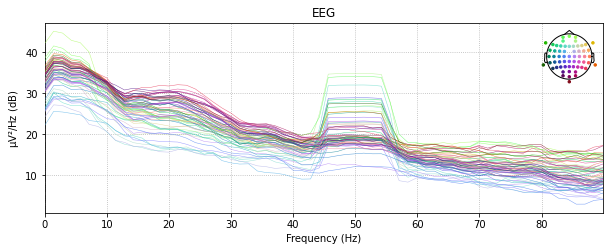

''

In [15]:
epoch_experience = epochs['experience']
fig = epoch_experience.plot_psd(fmax= 90)
fig.get_label()

## Rename and checking timing accuracy!

In [ ]:
# Rename the file if needed and upload them in Google drive
data_dir = '/content/drive/MyDrive/rename_temporary'
vhdr_file = op.join(data_dir, 'Confusion.vhdr')
vhdr_file_renamed = op.join(data_dir, 'hypnotist_confindu.vhdr')
copyfile_brainvision(vhdr_file, vhdr_file_renamed, verbose=True)

# Check that MNE-Python can read in both, the original as well as the renamed
# data (two files: their contents are the same apart from the name)
raw = mne.io.read_raw_brainvision(vhdr_file)
raw_renamed = mne.io.read_raw_brainvision(vhdr_file_renamed)

In [ ]:
# Check timing synchronization between EEG triggers and OpenSesame timestamps
## read csv file as pandas and find duration between timestamps
subject = pd.read_csv('/content/drive/MyDrive/plb_hyp_eeg_test/subject-1.csv')
subject = subject.tail(1)
triggers = [c for c in subject.columns if 'timestamp_' in c]
data = subject[triggers]
diff_csv = pd.to_datetime(data.iloc[0]).diff()

# trigInx = subject.columns.get_loc("timestamp_trigger_1")
# for i in range(5):
#   data = subject.iloc[:,trigInx:trigInx+i]
# data.insert(0,"timestamp_trigger_start",subject.loc[:,"timestamp_trigger_start"])

## read EEG marker files and calculate difference between timestamps
raw = mne.io.read_raw_brainvision('/content/drive/MyDrive/plb_hyp_eeg_test/plb-hyp-live0001.vhdr')
events, event_ids = mne.events_from_annotations(raw)

diff_eeg = np.ediff1d(events[:,0])
display(diff_csv)
display(pd.to_timedelta(diff_eeg,'ms').to_frame())

In [ ]:
data = data[['timestamp_trigger_1','timestamp_recording_posthyp_end']]
diff_csv = pd.to_datetime(data.iloc[0]).diff()

timestamp_trigger_1                                  NaT
timestamp_recording_posthyp_end   0 days 01:42:38.016796
Name: 17, dtype: timedelta64[ns]

In [ ]:
with open('/content/drive/MyDrive/plb_hyp_eeg_test/test_legacy.vmrk') as f:
  content = f.read()
print(content)

Brain Vision Data Exchange Marker File, Version 1.0

[Common Infos]
Codepage=UTF-8
DataFile=test_legacy.eeg

[Marker Infos]
; Each entry: Mk<Marker number>=<Type>,<Description>,<Position in data points>,
; <Size in data points>, <Channel number (0 = marker is related to all channels)>
; Fields are delimited by commas, some fields might be omitted (empty).
; Commas in type or description text are coded as "\1".
Mk1=New Segment,,1,1,0,20210220174458112327
Mk2=Stimulus,S  5,12896,1,0
Mk3=Stimulus,S  1,12897,1,0
Mk4=Stimulus,S  2,26288,1,0
Mk5=Stimulus,S  3,28102,1,0
Mk6=Stimulus,S  1,94547,1,0
Mk7=Stimulus,S  2,104455,1,0
Mk8=Stimulus,S  3,106525,1,0
Mk9=Stimulus,S  4,439950,1,0
Mk10=Stimulus,S  5,487872,1,0



In [ ]:
# xpiriment
baseline_len = 33.293810
pd.to_timedelta(diff_eeg[3],'ms')

# References
 - [MNE Python tutorials](https://mne.tools/stable/index.html)
